In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import backend as K
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os 
import multiprocessing
import wandb
# !pip install wandb -qqq
from wandb.keras import WandbCallback
import kerastuner as kt #!python3.x -m pip install keras-tuner
import cv2
from ipywidgets import fixed, interact 
import ipywidgets
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate, RandomBrightnessContrast, RandomCrop)


In [2]:
class Dataset_Classification(object): 
    """
     A dataset class usefull when training a classification model. 
    """
    def __init__(self, config): 
        self.config = config
        
        # set labels in a usefull format
        self._classification_labels()
        
        # initialize
        self.initialize()
        
        # to keep track of sampling
        self.sampling_check = np.zeros(20)
        self.times_sampled = 0
        
        
    def initialize(self):
        """
            Performs necessary thingss
        """
        self.train_data_path = 'data/train/img'
        self.test_data_path = 'data/test/img'
        
        # count nbr of files within data set. 
        self.nbr_of_train_images = len(os.listdir(self.train_data_path))
        self.nbr_of_test_images = len(os.listdir(self.test_data_path))
        
        # prepare train/validation split 
        train_fraction = self.config['train_fraction']
        r_idx=np.random.permutation(self.nbr_of_train_images)
        
        self.train_indices = r_idx[:int(train_fraction*self.nbr_of_train_images)]
        self.train_sample_probs = self.probabilities[self.train_indices]/np.sum(self.probabilities[self.train_indices])
        
        self.validation_indices = r_idx[int(train_fraction*self.nbr_of_train_images):]
        self.validation_sample_probs = self.probabilities[self.validation_indices]/np.sum(self.probabilities[self.validation_indices])
        
        print('Found {} train images'.format(self.nbr_of_train_images))
        print('- {} used for training, {} used for validating'.format(len(self.train_indices), len(self.validation_indices)))
        print('Found {} test images'.format(self.nbr_of_test_images))
        
        if self.config['augmentation']: 
            print('Including augmentation when training data is generated')
        self.augment = Compose([
                        #RandomCrop(width=self.config['input_shape'][0], height=self.config['input_shape'][0]),
                        HorizontalFlip(p=0.5),
                        RandomContrast(limit=0.1,p=0.25),
                        #RandomGamma(gamma_limit=(80, 120), p=0.5),
                        RandomBrightness(limit=0.15, p=0.5),
#                         HueSaturationValue(hue_shift_limit=1.5, sat_shift_limit=5,
#                                            val_shift_limit=2.5, p=.7),
                        # CLAHE(p=1.0, clip_limit=2.0),
                        ShiftScaleRotate(
                            shift_limit=0.1, scale_limit=0.1, 
                            rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
                    ])
    
        self.preprocessor = lambda x: x #defualt preprocessor does nothing 
        
    def get_test_set_size(self): 
        return self.nbr_of_test_images
    def get_train_set_size(self): 
        return self.nbr_of_train_images
        
    def reshape(self,im): 
        return cv2.resize(im, self.config['input_shape'])
        
    def _classification_labels(self): 
        """
            Get the classification labels 
        """
        # label names 
        train_df = pd.read_csv('data/train/train_set.csv', index_col="Id")
        self.label_names = train_df.columns.to_numpy()
        
        # get rid of pandas frame 
        self.labels = train_df.to_numpy() # each row corresponds to label
        
        # instances per class
        absolute_nbr_of_instances_per_class = np.sum(self.labels,axis=0)
        # get array with label name for each image 
        self.class_name_per_image = list()
        probabilities = list()
        total_class_prob = 1/20*np.ones(20)
        #total_class_prob[14]=0
        for row in self.labels: #can probably be done more eligant
            idx = np.where(row==1)[0]
            if 14 in idx:
                idx=14
            else:
                idx=idx[0]
            probabilities.append(total_class_prob[idx]/absolute_nbr_of_instances_per_class[idx])
            self.class_name_per_image.append(self.label_names[idx])
        
        
        # make sure total probability sums to 1
        if self.config['uniform_sample_probabilities']:
            self.probabilities = np.ones(np.array(probabilities).shape)/len(probabilities) # uniform sampling
        else:
            self.probabilities = np.array(probabilities)/np.sum(probabilities) # sampling based on distribution of classes in trainning data
            
            
    def feed_preprocess_function(self, preprocessor): 
        """
            Each network needs it's batches preprocessed in some manner. Feed this function to the Dataset object 
            who will call it when asking for batches.
            
            The preprocessor takes 
        """
        self.preprocessor = preprocessor
    
    def prepare_image(self, image): 
        """
            Function that performs all necessary steps from input image to image passed during trainnig. 
            This method should be overwritten depending on the model used.
        """
        h,w,c=image.shape
        # resize manually, when augmentation is turned on a random crop will be done 100% of times.
        #if not self.config['augmentation'] or h < self.config['input_shape'][0]or w < self.config['input_shape'][1]:
        image = self.reshape(image)

        # augment if augmentation is turned on 
        if self.config['augmentation']:
#             print('Augmentation enabled: check if combination of preprocessor and augmentation makes sence')
            image=self.augment(image=image)["image"]
        
        # preprocess 
        image = self.preprocessor(image)
        return image
    
    def prepare_test_image(self, image): 
        """
             Same as prepare_image but without augmentation
        """
        h,w,c=image.shape
        # resize manually, when augmentation is turned on a random crop will be done 100% of times.
        #if not self.config['augmentation'] or h < self.config['input_shape'][0]or w < self.config['input_shape'][1]:
        image = self.reshape(image)
        
        # preprocess 
        image = self.preprocessor(image)
        return image
    
    def view_preprocessed_image(self, image_id, option='train'): 
        """
            Shows an image as it is passed during training/testing of the network. 
            image_id 
        """
        assert hasattr(self, 'preprocessor'), 'set a preprocessor function before using this.'
        
        # get image 
        if option=='train':
            # get image 
            real_image = np.load('data/train/img/train_{}.npy'.format(image_id) )
            label = self.class_name_per_image[image_id]
        else: 
            real_image = np.load('data/test/img/test_{}.npy'.format(image_id) )
            label = 'unknown'
            
        image=np.copy(real_image)
        
        image = self.prepare_image(image)
        
    
    
        # print some info 
        print('original image:')
        print('-original_shape:', real_image.shape)
        print('-dtype:', real_image.dtype)
        print('-min value:', np.min(real_image))
        print('-max value:', np.max(real_image))
        
        print('final image:')
        print('-final shape:', image.shape)
        print('-dtype:', image.dtype)
        print('-min value:', np.min(image))
        print('-max value:', np.max(image))
        
        
        # show figure 
        fig, axes = plt.subplots(1,2, figsize=(30,15))
        axes[0].imshow(real_image)
        axes[0].set_title('Original image', fontsize=50)
        
        axes[1].imshow(image) # clip it to [0,1] range
        axes[1].set_title('preprocessed_image', fontsize=50)
        
        plt.suptitle('label: {}'.format(label), fontsize=50)
        fig.show()
        
    def view_possible_augmentations(self, image_id): 
        fig, axes = plt.subplots(4,4, figsize=(60,30))
        real_image = np.load('data/train/img/train_{}.npy'.format(image_id) )
        plt.suptitle('original image is on the top left', fontsize=50)
        for ax in axes.flat: 
            ax.imshow(self.augment(image=real_image)["image"])
            ax.axis('off')
        axes[0,0] = plt.imshow(real_image)
        fig.show()
        
        
    
    def train_generator(self,batch_size):
        """
            generator that will feed training batches during training 
        """
        inputs = []
        targets = []
        batchcount = 0
        while True:
#             for image_id in self.train_indices:
            image_id = np.random.choice(self.train_indices, p=self.train_sample_probs)
            # sample real image
            real_image = np.load('data/train/img/train_{}.npy'.format(image_id) )

            image = self.prepare_image(np.copy(real_image))
            inputs.append(image)

            # get corresponding label 
            targets.append(self.labels[image_id])
            
            self.sampling_check+=self.labels[image_id]
            self.times_sampled+=1
            

            batchcount += 1
            if batchcount >= batch_size:
                X = np.array(inputs)
                y = np.array(targets, dtype=np.uint8)
                yield (X, y)
                inputs = []
                targets = []
                batchcount = 0

    def validation_generator(self,batch_size):
        """
            generator that will feed validation batches during training 
        """
        inputs = []
        targets = []
        batchcount = 0
        while True:
            #for image_id in self.validation_indices:
            # sample real image
            image_id = np.random.choice(self.validation_indices,p=self.validation_sample_probs)
            real_image = np.load('data/train/img/train_{}.npy'.format(image_id) )

            image = self.prepare_test_image(np.copy(real_image))

            inputs.append(image)

            # get corresponding label 
            targets.append(self.labels[image_id])

            batchcount += 1
            if batchcount >= batch_size:
                X = np.array(inputs)
                y = np.array(targets, dtype=np.uint8)
                yield (X, y)
                inputs = []
                targets = []
                batchcount = 0           
    
    def test_generator(self,batch_size):
        """
            generator for feeding test data to model for prediction
        """
        inputs = []
        img_id = 0
        while img_id < self.nbr_of_test_images:
            raw_image = np.load('data/test/img/test_{}.npy'.format(img_id))
            image = self.prepare_test_image(np.copy(raw_image))
            inputs.append(image)
            img_id += 1
            if img_id%batch_size == 0:
                X = np.array(inputs)
                yield X
                inputs = []
        if len(inputs) > 0:
            return np.array(inputs)
    
    def show_class_distribution(self): 
        fig,axes=plt.subplots(figsize=(30,15))
        class_probs=np.mean(self.labels, axis=0)
        axes.bar(self.label_names,  class_probs)
        axes.tick_params(axis='both', which='major', labelsize=30)
        for tick in axes.xaxis.get_major_ticks():
            tick.label.set_rotation('vertical')
        plt.suptitle('Class distribution within the training data.', fontsize=50)
        fig.show()
        
    def show_training_sampling_distribution(self): 
        fig,axes=plt.subplots(figsize=(30,15))
        class_probs=np.mean(self.labels, axis=0)
        axes.bar(self.label_names,  self.sampling_check/self.times_sampled)
        axes.tick_params(axis='both', which='major', labelsize=30)
        for tick in axes.xaxis.get_major_ticks():
            tick.label.set_rotation('vertical')
        plt.suptitle('Number of times each class was sampled during training.', fontsize=50)
        fig.show()
    
    def get_class_distribution(self):
        return np.mean(self.labels, axis=0)

In [ ]:
dataset_config = {
    'train_fraction': 0.9,
    'input_shape': (224, 224),
    'augmentation': True, 
    'uniform_sample_probabilities': False
}
ds = Dataset_Classification(dataset_config)
ds.show_class_distribution()

In [ ]:
stop=0
for (X,y) in ds.train_generator(10):
    stop+=1
    print(X.shape)
    print(y.shape)
    
    if stop>10: 
        break
    

In [ ]:
import keras
from keras.models import Model 
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model
## identity block 
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

## Convolutional block
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [3]:
config = {
    'name': 'resnet50 custom implementation',
    'logging_wandb': False,  #nice tool for tracking a run. make and account on wandb.ai and I will add you to this project
    'weights': None, # 'imagenet', #None, 
    'nbr_classes': 20,
    'input_shape': (224, 224, 3),
    'train_base_model': True, # whether to train the head and or base model
    'train_head_model': True, 
    'train_parameters': {
        'epochs': 5,
        'batch_size': 32,
        'learning_rate': 0.01, 
        'steps_per_epoch': 500
    },
    'dataset': {
        'train_fraction': 0.9,
        'input_shape': (224, 224),
        'augmentation': True, # whether to augment images or not
        'uniform_sample_probabilities': False
    },
    'head_model': {
        'head_model_units': [512, 512], 
        'add_dropout':      [False, False],
        'activation': 'relu'
    }
}

In [117]:
# build generator and discriminator models 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
            

# base_model = ResNet50(input_shape=(224, 224, 3))

# headModel = base_model.output
# headModel = Flatten()(headModel)
# headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
# headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
# headModel = Dense(config['nbr_classes'],activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

# model=Model(inputs=base_model.input, outputs=headModel)

base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# fc1 = keras.layers.Dense(1024,  activation='relu')(avg)
# #d1=keras.layers.Dropout(0.4)(fc1)
# fc2 = keras.layers.Dense(512,  activation='relu')(fc1)
# #d2=keras.layers.Dropout(0.4)(fc2)
output = keras.layers.Dense(20, activation='softmax')(avg)
model=keras.Model(inputs=base_model.input, outputs=output)

# finetune 
for layer in base_model.layers: 
    layer.trainable=False
#model.summary()

1 Physical GPUs, 1 Logical GPUs


In [ ]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
dataset = Dataset_Classification(config['dataset'])
dataset.feed_preprocess_function(keras.applications.xception.preprocess_input)
clbcks=[]
history=model.fit(
            x = dataset.train_generator(batch_size=config['train_parameters']['batch_size']),
            steps_per_epoch = config['train_parameters']['steps_per_epoch'],
            epochs=config['train_parameters']['epochs'], 
            validation_data=dataset.validation_generator(batch_size=config['train_parameters']['batch_size']),
            validation_steps=50, 
            callbacks=clbcks
)

In [118]:
model.load_weights('Xception_finetuned.h5')
dataset = Dataset_Classification(config['dataset'])
dataset.feed_preprocess_function(keras.applications.xception.preprocess_input)

Found 749 train images
- 674 used for training, 75 used for validating
Found 750 test images
Including augmentation when training data is generated


In [8]:
# Loading the test data
test_df = pd.read_csv('data/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('data/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

# The test dataframe is similar to the training dataframe, but here the values are -1 --> your task is to fill in these as good as possible in Sect. 2 and Sect. 3; in Sect. 6 this dataframe is automatically transformed in the submission CSV!
test_df.head(1)

The test set contains 750 examples.


,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,img,seg
Id,,,,,,,,,,,,,,,,,,,,,
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,"[[[139, 130, 115], [136, 127, 112], [112, 102,...","[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."


In [ ]:
# for i in range(0,750):
#     test_data=test_df["img"].to_numpy()
#     im = test_data[i]
#     pre_im = dataset.prepare_test_image(im)
#     batch = np.expand_dims(pre_im, axis=0)

#     pred = model.predict(batch)
#     idx=np.argmax(pred)
#     score = np.round(pred[0][idx]/np.sum(pred),4)
#     label=dataset.label_names[idx]

#     plt.imshow(im)
#     plt.title('prediction: {}, score: {}'.format(label, np.round(100*score,2)))
#     plt.show()

In [ ]:
pred = model.predict(batch)

In [ ]:
idx=np.argmax(pred)
print(dataset.label_names[idx])

In [ ]:
model.save_weights('Xception_finetuned.h5')

In [151]:
import cv2 
from keras import backend as K
def show_heatmap(model, image_id):
    LAYER_NAME='block14_sepconv2_act'
    test_data=test_df["img"].to_numpy()
    im = test_data[image_id]
    pre_im = dataset.prepare_test_image(im)
    batch = np.expand_dims(pre_im, axis=0)

    pred = model.predict(batch)
    idx=np.argmax(pred)
    score = np.round(pred[0][idx]/np.sum(pred),4)
    label=dataset.label_names[idx]
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(batch)
        loss = predictions[:, idx]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    og_im = cv2.cvtColor(im.astype('uint8'), cv2.COLOR_RGB2BGR)
    
    og_im = cv2.resize(og_im, (224, 224))

    
    output_image = cv2.addWeighted(og_im, 0.7, cam, 1, 0)
    
    
    fig, axes = plt.subplots(1,2, figsize=(30,15))
    axes[1].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    axes[0].imshow(im)
    axes[0].set_title('prediction: {}, score: {}'.format(label, np.round(100*score,2)), fontsize=25)
    plt.show()

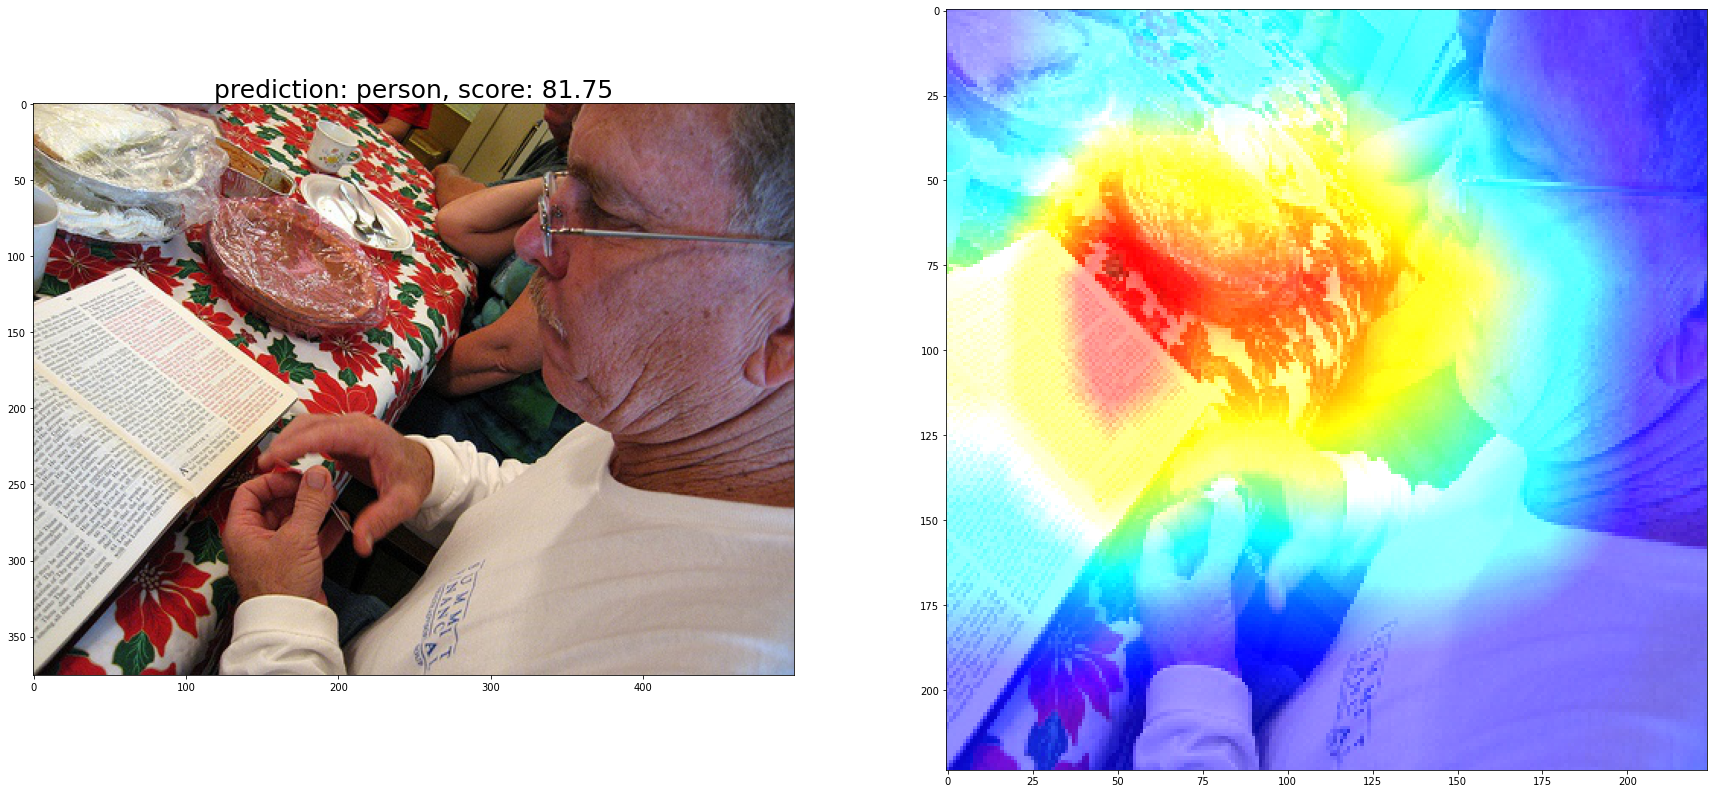

In [190]:
show_heatmap(model, 508)

In [139]:
model.summary()

Model: "model_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________